In [1]:
from parser import OpenCorporaParser
from artm import ARTM
from tools import get_pointwise_mutual_information
import numpy as np
import scipy.sparse as sparse
from combined_smoothing_sparsing_regularizer import CombinedSmoothingSparsingRegularizer
from covariance_docs_regularizer import CovarianceDocsRegularizer
from covariance_topics_regularizer import CovarianceTopicsRegularizer
from elimination_of_insignificant_topics import EliminationOfInsignificantTopics
import matplotlib.pyplot as plt
import pickle
from sparsing_regularizer import SparsingRegularizer
from classification_regularizer import ClassificationRegularizer
from sklearn.manifold import TSNE

### Parse OpenCorpora

In [2]:
open_corpora_parser = OpenCorporaParser()

doc_term_matr, vocabulary, year, topic, close_word_pairs = open_corpora_parser.parse_lemmatized_open_corpora()

In [3]:
def get_words_list(vocabulary):
    return np.array(sorted(vocabulary, key=lambda word: vocabulary[word]))

In [4]:
word_in_doc_freqs = doc_term_matr.transpose()

In [5]:
word_in_doc_freqs_train = sparse.dok_matrix(word_in_doc_freqs)

In [6]:
idx = np.where(word_in_doc_freqs_train.sum(axis=0) != 0)[1]
word_in_doc_freqs_train = word_in_doc_freqs_train[:, idx]

In [7]:
words_count = word_in_doc_freqs.shape[0]
docs_count = word_in_doc_freqs_train.shape[1]

In [8]:
close_word_pairs_train = np.array(close_word_pairs)[idx]
pmi = get_pointwise_mutual_information(word_in_doc_freqs_train, close_word_pairs_train)

In [9]:
topic = np.array(topic)[idx]

In [10]:
def train_model(regularizers, regularizer_weights, topics_count = 50):

    model = ARTM(topics_count=topics_count, regularizers=regularizers, regularizer_weights=regularizer_weights)

    #TODO: plot convergence to show that EM is implemented correctly.

    train_result = model.train(word_in_doc_freqs=word_in_doc_freqs_train,
                               words_list=get_words_list(vocabulary),
                               iterations_count=40, verbose=True, 
                               pointwise_mutual_information=pmi)
    return train_result

In [11]:
def plot_score(model, model_name):
    likelihoods = model.loglikelihoods
    pmis = model.pmi_metrics
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
    ax1.plot(likelihoods)
    ax1.set_title('Convergence of likelihood for the {}'.format(model_name))
    ax1.set_xlabel('# iteration')
    ax1.set_ylabel('likelihood')
    ax2.plot(pmis)
    ax2.set_title('Convergence of PMI metrics for the {}'.format(model_name))
    ax2.set_xlabel('# iteration')
    ax2.set_ylabel('PMI metrics')
    
    plt.show()
    
    print('Resulting perplexity = {}'.format(model.get_train_perplexity()))
    print('Resulting PMI = {}'.format(model.get_pointwise_mutual_information_metric()))

In [12]:
def plot_topics(model):
    X_topics = model.topic_in_doc_probs.T
    
    print('X_topics shape = {}'.format(X_topics.shape))
    threshold = 0.5
    idx = np.amax(X_topics, axis=1) > threshold  # idx of doc that above the threshold
    X_topics = X_topics[idx]
    
    print('X_topics shape = {} after theshholding'.format(X_topics.shape))

    # a t-SNE model
    # angle value close to 1 means sacrificing accuracy for speed
    # pca initializtion usually leads to better results 
    tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')

    # 20-D -> 2-D
    tsne_artm = tsne_model.fit_transform(X_topics)
    
    doc_topic = []
    for i in range(X_topics.shape[0]):
        doc_topic.append(X_topics[i].argmax())
    
    plt.figure(figsize=(15, 15))
    
    colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5", 
    '#b4261f', "#d66e13", "#994d0c", "#5eba0e", "#10d3c3", 
    "#0463f2", "#6b03f1", "#d502f0", "#ef01a4", "#ef0000", 
    "#cdf282", "#558442", "#558442", "#1e2528", "#0c7eaf", 
    "#463e87", "#673e87", "#5c079e", "#9e0770", "#9e0745", 
    "#f2c6c6", "#f1f1c5", "#daf0c4", "#c3efee", "#ebc3ef",
    "#8c4e55", "#ff001c", "#15ff00", "#ffd400", "#ff00ae"])
    plt.title('t-SNE projection of documents')
    for idx in np.unique(doc_topic):
        plt.scatter(tsne_artm[doc_topic == idx, 0], tsne_artm[doc_topic == idx, 1], 
                    label='topic {}'.format(idx), c=colormap[idx])
    #plt.legend()
    plt.show()
        

### Baseline model

In [13]:
train_result_baseline = train_model(regularizers=[], regularizer_weights=[])

iter#1: loglike=-244215.93799975535 pmi_metric=-0.01605174515847795
iter#2: loglike=-242315.97486864528 pmi_metric=0.001109159487425319
iter#3: loglike=-239492.7250563423 pmi_metric=0.025714591412447845
iter#4: loglike=-235101.40353338566 pmi_metric=0.05858358283342687
iter#5: loglike=-229046.00576024802 pmi_metric=0.09127565366154874
iter#6: loglike=-222312.22634533877 pmi_metric=0.11776615820243622
iter#7: loglike=-216282.63134731015 pmi_metric=0.13626397228869322
iter#8: loglike=-211608.99225581117 pmi_metric=0.14793795377076194
iter#9: loglike=-208176.06900912337 pmi_metric=0.1583122141086555
iter#10: loglike=-205643.57091012408 pmi_metric=0.16565208663635997
iter#11: loglike=-203727.0670995883 pmi_metric=0.17083078628367077
iter#12: loglike=-202233.08218070655 pmi_metric=0.17539736231763095
iter#13: loglike=-201038.70658433795 pmi_metric=0.17941903021945757
iter#14: loglike=-200065.65790257585 pmi_metric=0.18219257165790298
iter#15: loglike=-199262.78310019054 pmi_metric=0.1847718

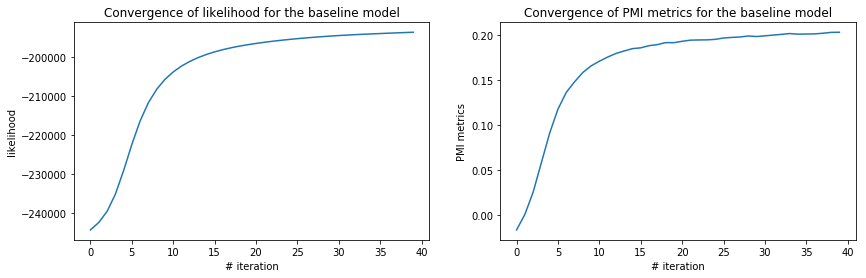

Resulting perplexity = 215.77101585850266
Resulting PMI = 0.20292431531627309


In [14]:
plot_score(train_result_baseline, 'baseline model')

In [15]:
pickle.dump(train_result_baseline, open('baseline.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

In [16]:
train_result_baseline.get_top_words_in_topics(top_words_count=10)

array([['размер', 'европа', 'средство', 'за', 'остальной', 'всегда',
        'получил', 'используюсь', 'на', '200'],
       ['мы', 'свой', 'за', 'на', 'человек', '22', '21', 'петербург', 'из',
        'отец'],
       ['кто', 'google', 'по', 'сторона', 'не', 'причина', 'картина',
        'они', 'судьба', 'другой'],
       ['искусство', 'архитектура', 'эволюция', 'франция', 'птица',
        'возрождение', 'живопись', 'австралия', 'новый', '60'],
       ['на', 'голос', 'игра', 'вышел', 'youtube', 'номер', 'разный',
        'пользователь', 'страница', 'не'],
       ['сказал', 'компания', 'который', 'президент', 'добавил', 'заявил',
        'стал', 'работа', 'частность', 'ноябрь'],
       ['из', 'один', 'isbn', 'план', 'татьяна', 'говорюсь', 'press',
        '978', 'лучший', 'случай'],
       ['имя', 'война', 'есть', 'по', 'молитва', 'центр', 'культура',
        'место', 'из', 'свой'],
       ['январь', 'работаю', 'на', 'есть', 'twitter', '11', 'москва',
        'открытие', 'опыт', 'програм

X_topics shape = (2610, 50)
X_topics shape = (1256, 50) after theshholding
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1256 samples in 0.001s...
[t-SNE] Computed neighbors for 1256 samples in 0.112s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1256
[t-SNE] Computed conditional probabilities for sample 1256 / 1256
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.171387
[t-SNE] Error after 1000 iterations: 0.353956


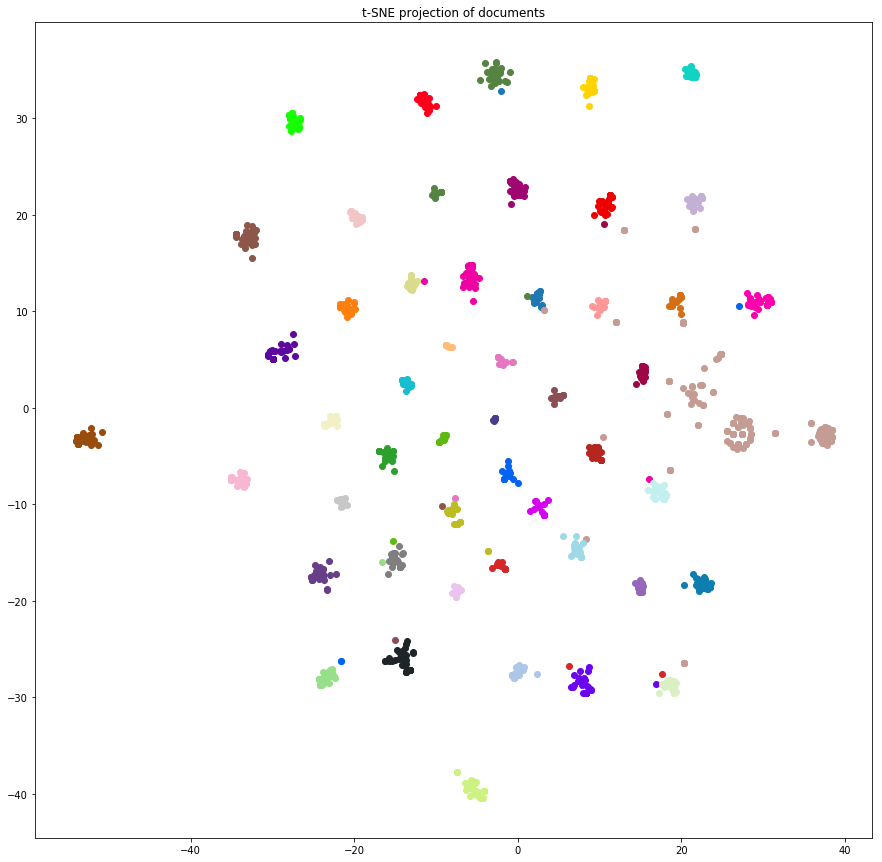

In [17]:
plot_topics(train_result_baseline)

### Adding regularizer

In [18]:
regularizers = [CovarianceTopicsRegularizer(tau=1.0, num_topics=50, num_words=words_count, num_docs=docs_count), 
               EliminationOfInsignificantTopics(tau=1.0, num_topics=50, 
                                                num_words=words_count, num_docs=docs_count, 
                                                word_in_doc_freqs=word_in_doc_freqs_train)]

regularizer_weights = [100., 100.]

In [19]:
train_result_regs = train_model(regularizers=regularizers, regularizer_weights=regularizer_weights)

iter#1: loglike=-264498.98952340503 pmi_metric=-0.01771163290198412
iter#2: loglike=-262366.02916073165 pmi_metric=0.0010936348969973334
iter#3: loglike=-259272.6468384837 pmi_metric=0.03067510956254031
iter#4: loglike=-254414.63061461126 pmi_metric=0.06612042311012468
iter#5: loglike=-247846.58330945158 pmi_metric=0.09913039281529165
iter#6: loglike=-240802.45839670041 pmi_metric=0.12400695107433973
iter#7: loglike=-234751.71493316494 pmi_metric=0.141093038623511
iter#8: loglike=-230213.32569173689 pmi_metric=0.15436393291250042
iter#9: loglike=-226944.02149541266 pmi_metric=0.16431495641056257
iter#10: loglike=-224563.1668791369 pmi_metric=0.1716331264883346
iter#11: loglike=-222780.71173411733 pmi_metric=0.17724229066338687
iter#12: loglike=-221399.71894083885 pmi_metric=0.18181514690204378
iter#13: loglike=-220300.74610837264 pmi_metric=0.18513515574834788
iter#14: loglike=-219409.50700237174 pmi_metric=0.18767298945866095
iter#15: loglike=-218680.01930355662 pmi_metric=0.189884952

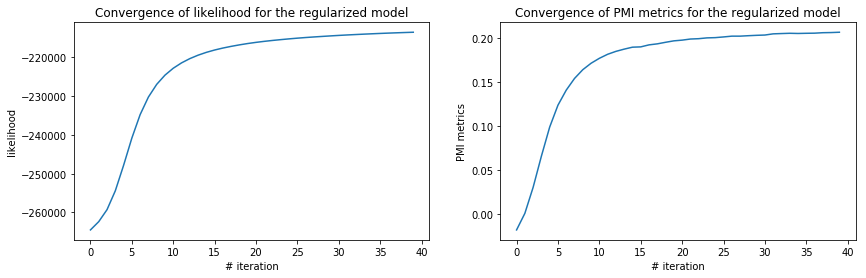

Resulting perplexity = 375.2052710047173
Resulting PMI = 0.2068620047304159


In [20]:
plot_score(train_result_regs, 'regularized model')

In [21]:
pickle.dump(train_result_regs, open('regs.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

In [22]:
train_result_regs.get_top_words_in_topics(top_words_count=10)

array([['есть', 'после', 'книга', 'из', 'имя', 'который', 'свой', 'вышел',
        'на', 'ход'],
       ['версия', 'стал', 'добавил', 'погиб', 'заключил', 'четыре',
        'смена', 'статистика', 'первый', 'пост'],
       ['на', 'наш', 'за', 'доллар', 'тысяча', 'неделя', 'сумма',
        'журналист', 'депутат', 'технология'],
       ['история', 'они', 'школа', '10', 'власть', 'культура', 'гарри',
        'один', 'который', 'личность'],
       ['20', 'право', 'на', 'год', '35', 'клинический', 'производство',
        'введение', 'отношусь', 'они'],
       ['страна', 'по', 'на', 'ура', 'иран', 'газета', 'провести',
        'ядерный', 'предложение', 'автомобиль'],
       ['ru', 'служба', 'рф', 'появился', 'http', 'com', 'апрель',
        'федеральный', 'суд', 'министерство'],
       ['рубль', 'турнир', 'участок', 'идея', 'экономический', '31',
        'эксперт', 'январь', 'до', '33'],
       ['дмитрий', 'структура', 'медведев', 'решение', 'на', 'система',
        'письмо', 'youtube', 'объе

X_topics shape = (2610, 50)
X_topics shape = (1494, 50) after theshholding
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1494 samples in 0.002s...
[t-SNE] Computed neighbors for 1494 samples in 0.156s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1494
[t-SNE] Computed conditional probabilities for sample 1494 / 1494
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.703270
[t-SNE] Error after 1000 iterations: 0.402711


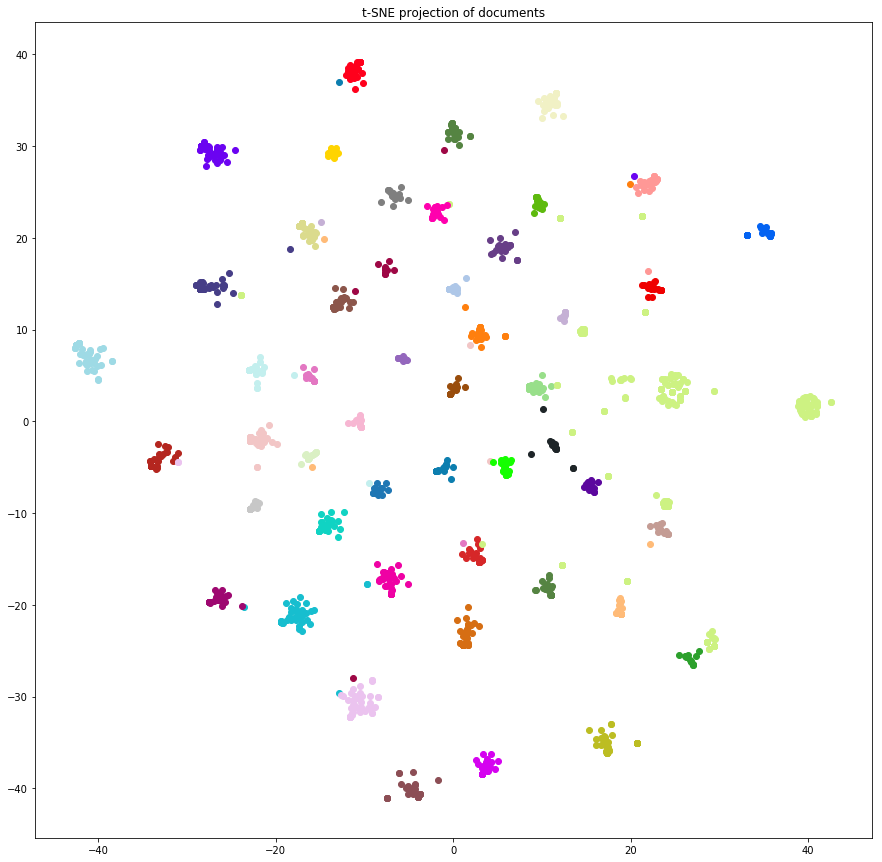

In [23]:
plot_topics(train_result_regs)

### Sparsing regularizer

In [24]:
topics_count = 50

In [25]:
regularizers = [SparsingRegularizer(beta_0=0.5, alpha_0=0.5, 
                                    beta=np.array([1e-4]*words_count), 
                                    alpha=np.array([1e-4]*topics_count),
                                    num_topics=topics_count, 
                                    num_words=words_count, 
                                    num_docs=docs_count)]

regularizer_weights = [10.]

In [26]:
train_result_sparse = train_model(regularizers=regularizers, regularizer_weights=regularizer_weights)

iter#1: loglike=-243515.54810523023 pmi_metric=-0.014609406735683768
iter#2: loglike=-241583.2296414824 pmi_metric=0.0005326227354549613
iter#3: loglike=-238743.46359100088 pmi_metric=0.028568766993133873
iter#4: loglike=-234379.7118668917 pmi_metric=0.05889462502882289
iter#5: loglike=-228365.78997212456 pmi_metric=0.08750498411148579
iter#6: loglike=-221545.01692613194 pmi_metric=0.11122636785190736
iter#7: loglike=-215211.55963284132 pmi_metric=0.12953114276201572
iter#8: loglike=-210112.61195381838 pmi_metric=0.1436552626646832
iter#9: loglike=-206297.48179877852 pmi_metric=0.1536836293475557
iter#10: loglike=-203519.08895173177 pmi_metric=0.1607170083377129
iter#11: loglike=-201478.39818244005 pmi_metric=0.16695381129841438
iter#12: loglike=-199941.8828436001 pmi_metric=0.17334082670012063
iter#13: loglike=-198756.20725928928 pmi_metric=0.17758981901050497
iter#14: loglike=-197818.57036603172 pmi_metric=0.1804524194395942
iter#15: loglike=-197052.70204615925 pmi_metric=0.183576396

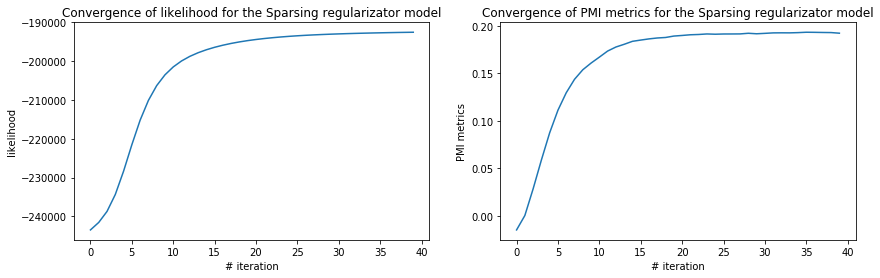

Resulting perplexity = 209.67774484980225
Resulting PMI = 0.19211618313505505


In [27]:
plot_score(train_result_sparse, 'Sparsing regularizator model')

In [28]:
train_result_sparse.get_top_words_in_topics(top_words_count=10)

array([['книга', 'иваныч', 'игнатий', 'можно', 'теория', 'характеристика',
        'на', 'использование', 'выставка', 'порфирий'],
       ['свой', 'сегодня', 'дмитрий', 'сумма', 'примечание', 'медведев',
        'афганистан', 'работа', 'реклама', 'на'],
       ['президент', 'страна', 'интернет', 'проблема', 'журналист',
        'который', 'по', 'сеть', 'социальный', 'обама'],
       ['такой', 'бы', 'от', 'до', 'могу', 'если', 'весь', '24',
        'средство', 'европа'],
       ['на', '22', 'машина', 'есть', 'для', 'мкс', 'действие', 'по',
        'sts', 'вывод'],
       ['новый', 'российский', '12', 'федерация', '16', 'волна',
        'частность', 'первый', 'аргумент', '2009'],
       ['статья', '28', 'корабль', 'суд', 'россиянин', 'депутат', '15',
        'поэт', 'союз', '30'],
       ['отметил', 'без', 'рассказал', 'по', 'лента', 'для', 'фильм', 'ру',
        'пояснил', 'герой'],
       ['за', '10', 'область', 'на', 'появился', 'есть', 'остался',
        'неделя', 'премия', 'иран'],


X_topics shape = (2610, 50)
X_topics shape = (1292, 50) after theshholding
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1292 samples in 0.001s...
[t-SNE] Computed neighbors for 1292 samples in 0.134s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1292
[t-SNE] Computed conditional probabilities for sample 1292 / 1292
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.481209
[t-SNE] Error after 1000 iterations: 0.282519


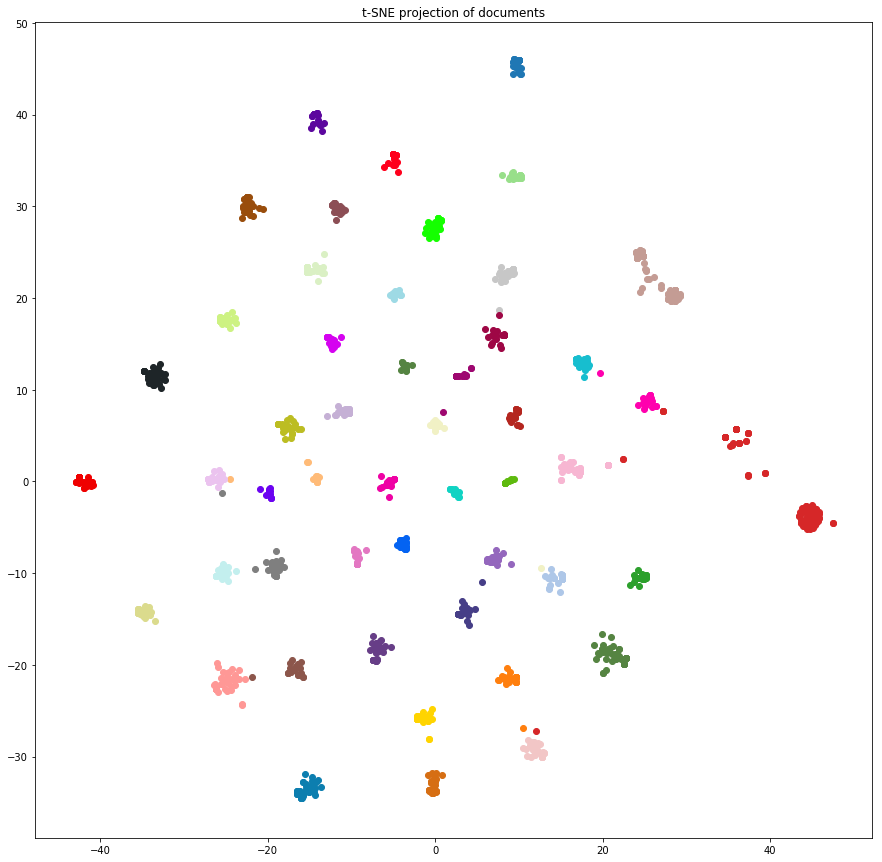

In [29]:
plot_topics(train_result_sparse)

### Classification regularization

In [30]:
regularizers = [ClassificationRegularizer(tau=1.0, num_topics=50, num_docs=docs_count, 
                                          docs_classes=topic, num_words=words_count, 
                                          docs_freq=np.array(word_in_doc_freqs_train.sum(axis=0)))]

regularizer_weights = [10.]

In [31]:
train_result_class = train_model(regularizers=regularizers, regularizer_weights=regularizer_weights)

iter#1: loglike=-1177193.3230954995 pmi_metric=-0.014144852342381775
iter#2: loglike=-1057163.927537454 pmi_metric=0.0003223425330107257
iter#3: loglike=-876315.2060348089 pmi_metric=0.027931218692166537
iter#4: loglike=-686082.1749265592 pmi_metric=0.06564647454187349
iter#5: loglike=-549172.9742317687 pmi_metric=0.08842797508556519
iter#6: loglike=-471558.24238391046 pmi_metric=0.10391749866833853
iter#7: loglike=-428188.5284953539 pmi_metric=0.11428777418503154
iter#8: loglike=-399758.2409740669 pmi_metric=0.12160675445587765
iter#9: loglike=-380121.6316372401 pmi_metric=0.12602664773315797
iter#10: loglike=-367674.7143344139 pmi_metric=0.12795453926476966
iter#11: loglike=-360712.2677968737 pmi_metric=0.13102799138326693
iter#12: loglike=-356254.5628956307 pmi_metric=0.13311503764376592
iter#13: loglike=-353295.2468090596 pmi_metric=0.13539349596417444
iter#14: loglike=-351079.35689191957 pmi_metric=0.13600925028888664
iter#15: loglike=-348984.12110323063 pmi_metric=0.1382446914568

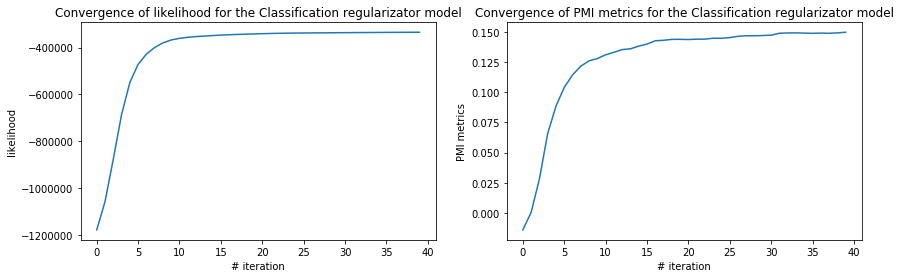

Resulting perplexity = 10876.045568464458
Resulting PMI = 0.14975980369156597


In [32]:
plot_score(train_result_class, 'Classification regularizator model')